In [1]:
# (c) 2019
# Sanne de Smet
# Sjoerd Gnodde

# Hydrological Fieldwork 2019
# Group 4

# Code reading data from the Sontek device

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spio
import getpass
import os
import csv

In [13]:
########## Variables #############
Blank_zone = 0.11
#Vbeam = 7.32 # distance of vertical sample
tierap = "3" # The tierap being looked at right now

device = 'Sontek' # What device am I using here

plot_vert_prof = True # Plot vertical profile
save_vert_prof = False # Save vertical profile to file

plot_cross_sec = False

save_mid_depths = True

save_extra_width = False

folder_file_save = "../output_images/{}.png"
folder_csv_save = "../data/{}.csv"
depths_adcp_for_adv = folder_csv_save.format('depths_adcp_for_adv_{}'.format(device))
diff_travel_sontek = folder_csv_save.format('diff_travel_{}'.format(device))
##################################

In [14]:
# Was function smartpulsehd on?
smartpulsehd = np.array([1, 1, 0, 0, 0, 1])

# Number of days in total
numdays = 6

# Name of the computer
myhost = getpass.getuser()

# Base folder
datafolder = 'C:/Users/username/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/'.replace('username', myhost)# basefolder
basefolder = datafolder+device

# Subfolders
daynames = [i[3:] for i in os.listdir(basefolder)]

# Four different qs per time period
allqs = [np.zeros(numdays) for i in range(4)]


# Test tierap
try: 
    tierap = int(tierap)
    print("Transect {} used".format(tierap))
except:
    print("Transect {} used".format(tierap))

# Open Excel with ADV results
advexcel = datafolder+'ADVmeasurements.xlsx'

Transect 3 used


Monday morning
20051002095139.mat 0
Transducerdepth:  Monday morning 20051002095139.mat 0.07
Extra dist:  1.1038699407486519
Right dist:  0.42
20051002095859.mat 1
Transducerdepth:  Monday morning 20051002095859.mat 0.07
Extra dist:  0.31136625833449116
Right dist:  0.42
20051002100742.mat 0
Transducerdepth:  Monday morning 20051002100742.mat 0.07
Extra dist:  0.06811092378423211
Right dist:  0.42
20051002101138.mat 1
Transducerdepth:  Monday morning 20051002101138.mat 0.07
Extra dist:  0.6451832674854483
Right dist:  0.42
Depths in middle:
[0.18  0.205 0.41  0.47  0.48  0.48  0.    0.    0.   ]

Mean Qs 0
Mean right Q =  0.0003096332057860718 m^3/s
Mean left Q =  0.0 m^3/s
Mean top Q =  0.4411686607700176 m^3/s
Mean middle Q =  1.2061205504626862 m^3/s
Sum all 1.6479084776442758
Total Q 2.0281638998179554

Monday afternoon
20051002153808.mat 0
Transducerdepth:  Monday afternoon 20051002153808.mat 0.07
Extra dist:  0.7022563539522277
Right dist:  0.42
20051002154435.mat 1
Transducerdep

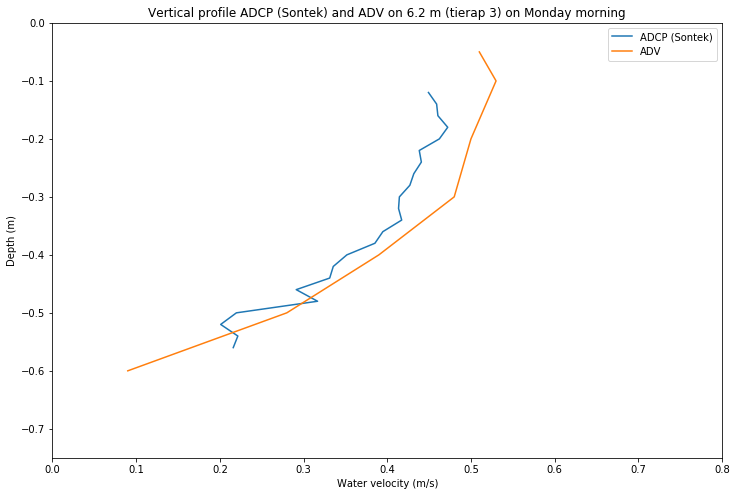

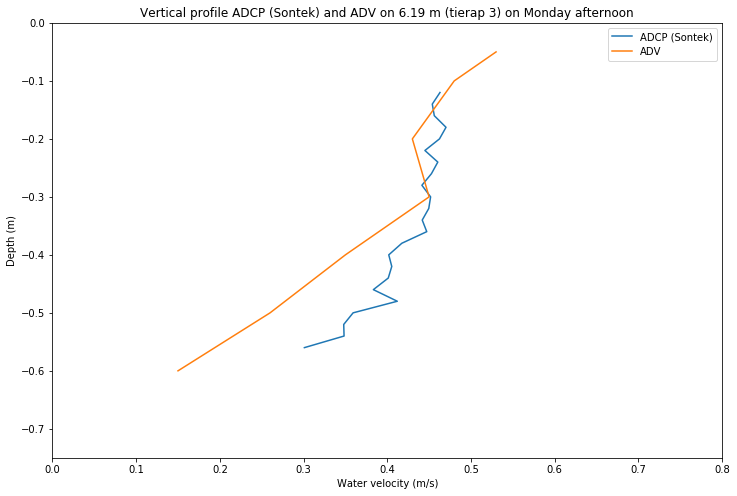

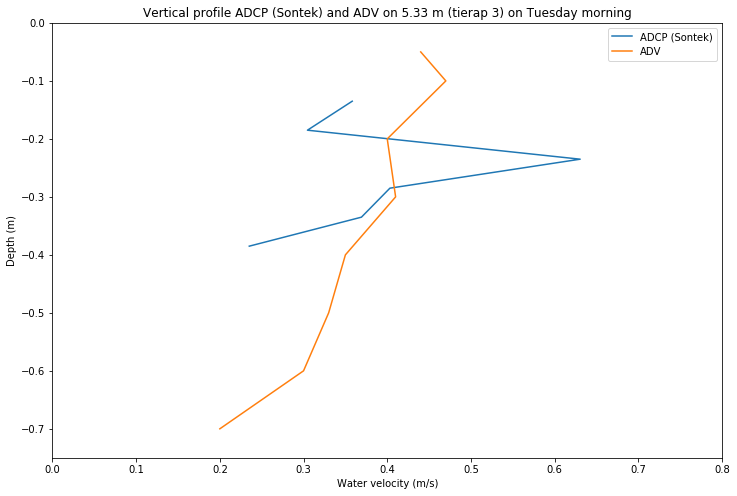

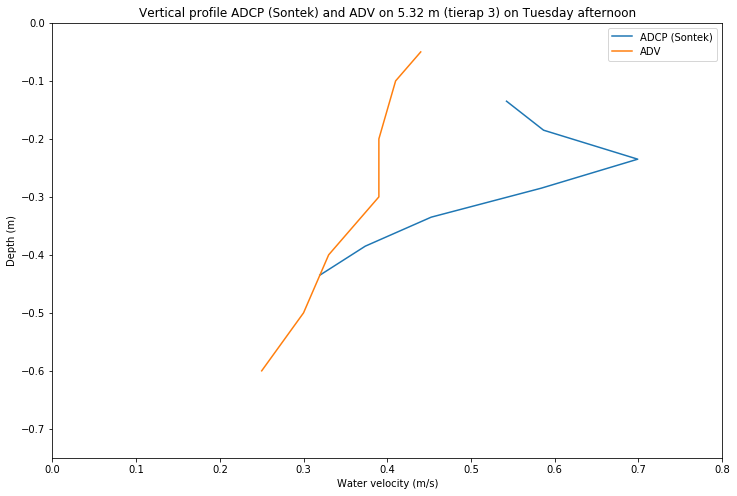

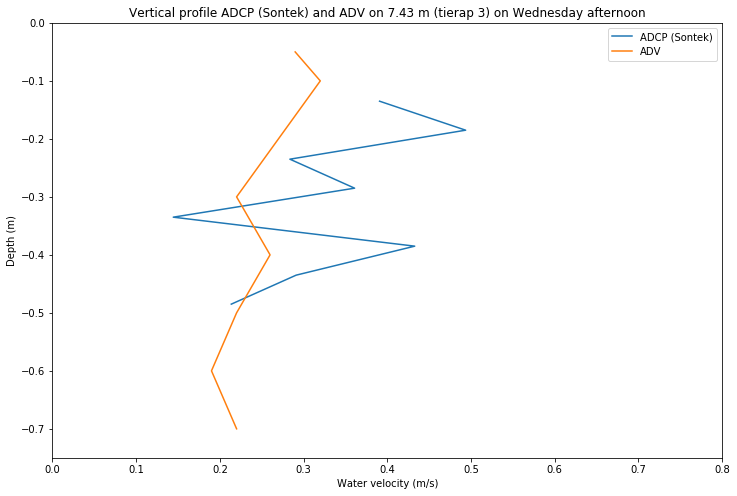

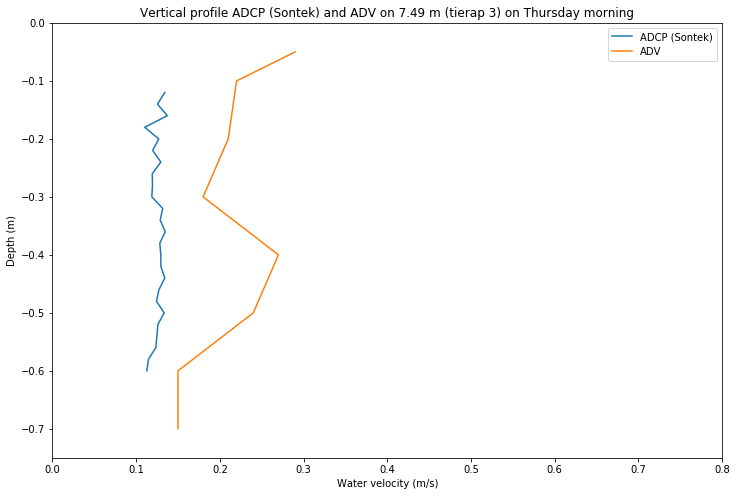

In [15]:
# Count the number of days
day = 0


# loop over all roots
for root, dirs, files in os.walk(basefolder, topdown=False):
    
    # Don't look in the basefolder
    if root == basefolder:
        continue
        
    # which folder are we doing right now?
    print(daynames[day])
    
    
    # Per time period, save the number of depth cells
    tot_xs = {}
    len_xs = 1000
    
    # Files that we want to use
    goodfiles = [file for file in files if (file[-4:] == '.mat') and (file[-5:] != 'y.mat')] 
    
    # Total Qs to be saved
    tot_rightq = np.zeros(len(goodfiles))
    tot_leftq = np.zeros_like(tot_rightq)
    tot_topq = np.zeros_like(tot_rightq)
    tot_middleq = np.zeros_like(tot_rightq)
    
    # Read the Excel of the ADV measurements
    adv = pd.read_excel(advexcel, sheet_name=daynames[day])
    meas_locs = adv.iloc[2, 1:].dropna()
    
    # Set Vbeam
    Vbeam = adv[tierap][2]

    # Save depths in middle
    tot_middepths = np.zeros((len(meas_locs), len(goodfiles)))
    
    # Remember the number of the file
    filenum = 0
    
    # Loop over the correct files in the folder
    for file in goodfiles:
        
        # Load direction from file in folder
        direction = int(np.loadtxt(root+'/direction.txt', delimiter = ',')[filenum])
        print(file, direction)

        # Load the file
        matfile = root+'/'+file
        mat = spio.loadmat(matfile)
        
        
        ### Qs ###
        # Load the extrapolated qs
        RightQ = mat['Summary']['Right_Q'][()][0][0][-1][0]
        LeftQ = mat['Summary']['Left_Q'][()][0][0][-1][0]
        TopQ = mat['Summary']['Top_Q'][()][0][0][-1][0]
        # Load calculated 
        MiddleQ = mat['Summary']['Middle_Q'][()][0][0][-1][0]
        BottomQ = mat['Summary']['Bottom_Q'][()][0][0][-1][0]
        TopQ = mat['Summary']['Top_Q'][()][0][0][-1][0]
        # Load total discharge
        Discharge   = mat['Summary']['Total_Q'][()][0][0]     # discharge
        
        # Save total Qs such that average can be taken
        tot_rightq[filenum] = RightQ
        tot_leftq[filenum] = LeftQ
        tot_topq[filenum] = TopQ
        tot_middleq[filenum] = MiddleQ

        # Print the transducerdepth
        TransducerDepth = mat['Setup']['sensorDepth'][()][0][0][0][0]
        print('Transducerdepth: ', daynames[day], file, TransducerDepth)

        Vmean = mat['Summary']['Mean_Vel'][()][:,0][0][0] # = nanmean(Vprofile,1)   # average velocity averaged over the depth   

        # Load measured depth per column
        Depth = mat['Summary']['Depth'][()][0][0] 
        
        # Load the number of cells per column
        Cells = (mat['Summary']['Cells'][()])[0][0]#.astype('int')                   # number of cells for each vertical beam
        Cells = np.array([int(Cells[i][0]) for i in range(len(Cells))])
        
        # Load cell sizes
        Cellsize = mat['System']['Cell_Size'][()][0][0]
        Cellsize = np.array([round(Cellsize[i][0],4) for i in range(len(Cells))])
  
        
        # Load the track of the boat
        Track = mat['Summary']['Track'][()][0][0]    # track location for each sample in X/Y coordinates
        Track_x = np.array([Track[i][0] for i in range(len(Track))])
        Track_y = np.array([Track[i][1] for i in range(len(Track))])
        Distance = np.array([(Track_x[i]**2+Track_y[i]**2)**0.5 for i in range(len(Track_x))]) #np.sum(abs(Track),1)    #this is probably not be correct and it depends how Track is measured. Please check this!

        # Load velocity for each of the four beams
        Velocity = mat['WaterTrack']['Velocity'][()][0][0]       # velocity for each of the 4 beams

        if direction==1:  # flip if reverse
            Distance = np.max(Distance)-Distance
            Velocity = - Velocity
        
        Vabs = (Velocity[:,0,:]**2+Velocity[:,1,:]**2)**0.5  # average velocity profile
        
        # Velocity in the direction of the river
        Vprofile = np.abs(Velocity[:,0,:]) # this is only the x direction. Taken as positive for all.
        
        if plot_cross_sec:
            plt.figure(figsize=(8,12))
            plt.imshow(Vprofile[:20, :])
        
        # Depths in the measured area
        Middepths = Cells*Cellsize
        
        # Take out of the middle depths for comparison with the ADV
        for k in range(len(meas_locs)):
            dist_to_loc = np.array([abs(Distance[i]-meas_locs[k]) for i in range(len(Distance))])
            loc_cell = np.argmin(dist_to_loc)
            tot_middepths[k, filenum] = Middepths[loc_cell]
            
                
        ###  Extra distances ###
        LeftDist = mat['Setup']['Edges_0__DistanceToBank'][()][0][0][0][0]
        midlen = np.max(meas_locs) # starts with 0, so take maximum value
        leftplusmid = LeftDist + midlen
        RightDist = mat['Setup']['Edges_1__DistanceToBank'][()][0][0][0][0]
        travel_boat = np.max(Distance)
        extra_dist = travel_boat - midlen
        print("Extra dist: ", extra_dist)
        
        print("Right dist: ", RightDist)
        if save_extra_width: 
            with open(diff_travel_sontek, 'a', newline = "") as csv_file_dif:
                line_extra_width = [daynames[day], file, extra_dist]

                csv_writer = csv.writer(csv_file_dif)
                csv_writer.writerow(line_extra_width)

        # Plot the track
        #plt.figure()
        #plt.plot(Track_x, Track_y)
        #plt.axis('equal')

        # Depth_BT    = mat['BottomTrack']['BT_Depth'][()][0][0] # bottom track (BT) depth using 4 beams at 3MHz frequency (smaller depth range, higher resolution). The depth is estimated assuming the river bed does not move and using boat movement information.
        #DepthBeam   = mat['BottomTrack']['BT_Beam_Depth'][()][0][0]                       # total water depth for each beam

        dist_to_vbeam = np.array([abs(Distance[i]-Vbeam) for i in range(len(Distance))])

        Vbeam_cell = np.argmin(dist_to_vbeam)

        y_axis = -Blank_zone-Cellsize[Vbeam_cell]*np.linspace(0.5, Cells[Vbeam_cell]-0.5,Cells[Vbeam_cell])
        x_axis =  Vprofile[0:Cells[Vbeam_cell], Vbeam_cell]

        # x_axis = np.array([(x_axis[i]*2+x_axisplus1[i]+x_axisminus1[i])/4 for i in range(minsides)])
        tot_xs[file] = x_axis

        if len(x_axis) < len_xs:
            len_xs = len(x_axis)
            tot_ys = y_axis #[0:minsides]

        '''
        plt.figure()
        plt.plot(-Depth, 'b')

        plt.plot(-Cellsize*np.array(Cells)-Blank_zone, 'r')
        plt.plot([0,len(Cells)], [-Blank_zone, -Blank_zone], 'r')
        plt.plot([0,len(Cells)], [0,0], 'b')
        '''         
        filenum +=1
    
    # Process the middle depth values
    if save_mid_depths:
        with open(depths_adcp_for_adv, 'a', newline = "") as csv_file:
            avg_middepths =  np.zeros(len(meas_locs))
            for i in range(len(meas_locs)):
                avg_middepths[i] = np.mean(tot_middepths[i, :])

            print("Depths in middle:")
            print(avg_middepths)

            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([daynames[day]]+[l for l in avg_middepths])

    
    
    # Process the vertical profile
    x_axis_tot = np.zeros(len_xs)
    
    for j in range(len_xs):     #depths
        level_tot = np.zeros(len(goodfiles))
        
        i = 0
        for file in goodfiles: #files
            level_tot[i] = tot_xs[file][j]
            i+=1
                
        x_axis_tot[j] = np.mean(level_tot)
    
    # Plot vertical velocity profile
    if plot_vert_prof:
        plt.figure(figsize=(12,8))
        
        # Plot ADCP
        plt.plot(x_axis_tot, tot_ys, label = "ADCP ({})".format(device))
        plt.ylim((-.75,0))
        plt.xlim((0, 0.8))
        plt.xlabel('Water velocity (m/s)')
        plt.ylabel('Depth (m)')
        plt.title('Vertical profile ADCP ({}) and ADV on {} m (tierap {}) on {}'.format(device, round(Vbeam, 2), tierap, daynames[day]))
        
        # Plot ADV
        adv_depths = adv['Transect #'][4:]
        adv_vels = adv[tierap][4:]
        plt.plot(adv_vels, adv_depths, label = "ADV")
        plt.xlim(0) 
        plt.legend()
        
        
        
        if save_vert_prof:
            plt.savefig(folder_file_save.format('Vert_prof_vbeam_'+device+'_'+str(Vbeam).replace('.',',')+'_'+ daynames[day]), dpi=300)

    # Means of the Qs
    mean_rightq = np.mean(tot_rightq)
    mean_leftq = np.mean(tot_leftq)
    mean_topq = np.mean(tot_topq)
    mean_middleq = np.mean(tot_middleq)

    # Print means
    print()
    print('Mean Qs', day)
    print('Mean right Q = ', mean_rightq, 'm^3/s')
    print('Mean left Q = ', mean_leftq, 'm^3/s')
    print('Mean top Q = ', mean_topq, 'm^3/s')
    print('Mean middle Q = ', mean_middleq, 'm^3/s')
    print('Sum all', sum((mean_rightq, mean_rightq, mean_topq, mean_middleq)))
    print('Total Q', Discharge[-1][0])

    # Save means
    allqs[0][day] = mean_rightq
    allqs[1][day] = mean_leftq
    allqs[2][day] = mean_topq
    allqs[3][day] = mean_middleq
        
    print()
    day += 1


<Figure size 504x504 with 0 Axes>

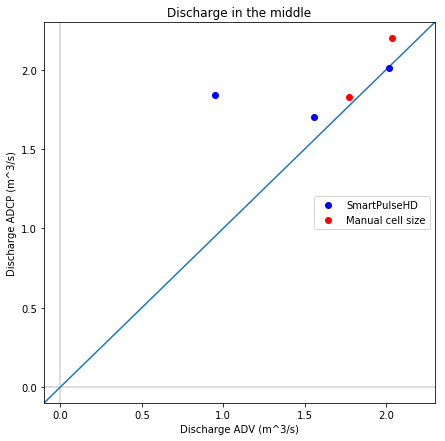

<Figure size 504x504 with 0 Axes>

In [6]:
rightadv = np.array([0.04, 0.05, 0.04, 10000,  0.07, 0.06])
leftadv = np.array([0.03, 0.03, 0.07, 10,  0.06, 0.1])
middleadv = np.array([0.95, 1.56, 1.77, 100,  2.04, 2.02])



plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])
plt.xlim((-.1, 2.3))
plt.ylim((-.1, 2.3))

plt.plot(middleadv[smartpulsehd==1], allqs[3][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(middleadv[smartpulsehd==0], allqs[3][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the middle')
plt.savefig('figure1.png')

plt.figure(figsize=(7,7))


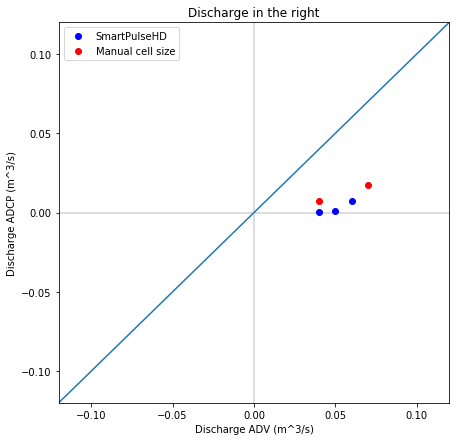

In [7]:
plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])

plt.xlim((-0.12, 0.12))
plt.ylim((-0.12, 0.12))

plt.plot(rightadv[smartpulsehd==1], allqs[0][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(rightadv[smartpulsehd==0], allqs[0][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the right')
plt.savefig('figure2.png')


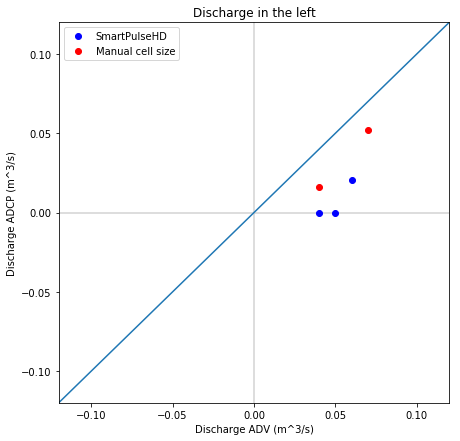

In [8]:
plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])
plt.xlim((-0.12, 0.12))
plt.ylim((-0.12, 0.12))

plt.plot(rightadv[smartpulsehd==1], allqs[1][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(rightadv[smartpulsehd==0], allqs[1][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the left')
plt.savefig('figure3.png')

In [9]:
# get depths

In [10]:
# loop over all roots
for root, dirs, files in os.walk(basefolder, topdown=False):
    

        
    # which folder are we doing right now?
    print(root)
    
    # Per time period, save the number of depth cells
    tot_xs = {}
    len_xs = 1000
    
    # Files that we want to use
    goodfiles = [file for file in files if (file[-4:] == '.mat') and (file[-5:] != 'y.mat')] 
    
    # Total Qs to be saved
    tot_rightq = np.zeros(len(goodfiles))
    tot_leftq = np.zeros_like(tot_rightq)
    tot_topq = np.zeros_like(tot_rightq)
    tot_middleq = np.zeros_like(tot_rightq)
    
    filenum = 0

C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\1. Monday morning
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\2. Monday afternoon
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\3. Tuesday morning
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\4. Tuesday afternoon
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\6. Wednesday afternoon
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\7. Thursday morning
C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek


In [40]:
testarray = np.array([1,2,3])
np.arctan(0.5-testarray)

array([-0.46364761, -0.98279372, -1.19028995])

In [52]:
np.arctan(1)

0.7853981633974483

        Transect #     1a     1b     1c       2      3     4    4b     5a  \
0   Tie wrap color    Red   Blue  Green  Yellow  Black  Blue   Red  Green   
1   x-distance [m]      -      -      -       -      -     -     -      -   
2         Location  15.74  15.32  14.86    9.48   7.49  5.51  0.81   0.41   
3            Depth      -      -      -       -      -     -     -      -   
4            -0.05      0   0.01   0.01     0.1   0.29  0.36  0.14   0.07   
5             -0.1      0   0.01   0.01    0.08   0.22  0.37   0.1   0.07   
6             -0.2   0.02   0.02   0.02    0.09   0.21  0.34  0.09   0.08   
7             -0.3    NaN   0.01   0.01    0.09   0.18  0.39  0.05    NaN   
8             -0.4    NaN   0.04      0    0.08   0.27  0.35   NaN    NaN   
9             -0.5    NaN    NaN    NaN    0.08   0.24  0.38   NaN    NaN   
10            -0.6    NaN    NaN    NaN    0.09   0.15  0.31   NaN    NaN   
11            -0.7    NaN    NaN    NaN    0.09   0.15  0.29   NaN    NaN   

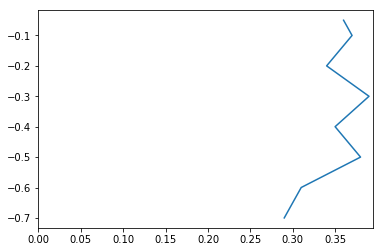

In [67]:
day = 5
adv = pd.read_excel(advexcel, sheet_name=daynames[day])
print(adv)
transect = "4"
try: 
    transect = int(transect)
    print("Transect {} used".format(transect))
except:
    print("Transect {} used".format(transect))

adv_depths = adv['Transect #'][4:]

adv_vels = adv[transect][4:]
plt.plot(adv_vels, adv_depths)
plt.xlim(0)

Vbeam = adv[transect][2]
print(Vbeam)
    
